## Importing libraries

In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from pathlib import Path
from PIL import ImageDraw, Image
import torch
import torchvision.transforms.functional as tf
from torchvision.transforms import Compose
from torch.utils.data import Dataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data Loading

In [2]:
dataset = load_dataset("keremberke/license-plate-object-detection", "full")

In [3]:
print(dataset['train']) # showing how the dataset is composed
print(dataset['test'])
print(dataset['validation'])

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 6176
})
Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 882
})
Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 1765
})


Keeping only relevant information

In [4]:
training = pd.DataFrame(columns = ['image', 'bbox'])
training['image'] = [dataset['train'][el]['image'] for el in dataset['train']['image_id']]
training['bbox'] = [dataset['train'][el]['objects']['bbox'][0] for el in dataset['train']['image_id']]

In [5]:
validation = pd.DataFrame(columns = ['image', 'bbox'])
validation['image'] = [dataset['validation'][el]['image'] for el in dataset['validation']['image_id']]
validation['bbox'] = [dataset['validation'][el]['objects']['bbox'][0] for el in dataset['validation']['image_id']]

In [6]:
test = pd.DataFrame(columns = ['image', 'bbox'])
test['image'] = [dataset['test'][el]['image'] for el in dataset['test']['image_id']]
test['bbox'] = [dataset['test'][el]['objects']['bbox'][0] for el in dataset['test']['image_id']]

In [7]:
print(training.head())
print(validation.head())
print(test.head())

                                               image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                bbox  
0                         [237.0, 112.0, 85.0, 64.0]  
1  [408.0, 484.0, 71.04000091552734, 17.290063858...  
2                        [248.0, 146.0, 102.0, 30.0]  
3                         [172.0, 183.0, 92.0, 75.0]  
4                         [248.0, 153.0, 98.0, 72.0]  
                                               image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=... 

Here I show some examples of the train dataset along with the bounding boxes

In [8]:
def show_image_with_bb(image, bbox):
    image = image.copy()
    x, y, w, h = bbox
    ImageDraw.Draw(image).rectangle([(x, y), (x+w, y+h)], outline='green', width=4)
    plt.imshow(image, aspect='equal')

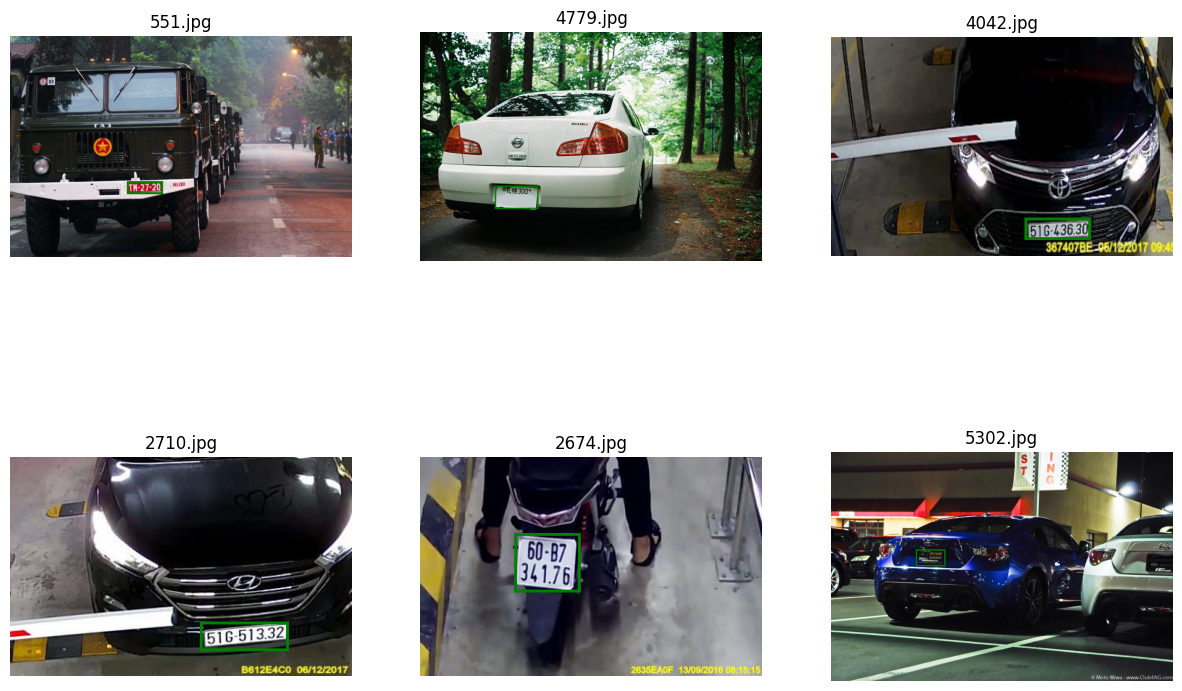

In [9]:
rng = np.random.default_rng(42)
n_cols = 3
n_rows = 2
indexes = rng.choice(len(training), n_cols * n_rows)

plt.figure(figsize=(15, 10))

for ii, id in enumerate(indexes, 1):
    plt.subplot(n_rows, n_cols, ii)
    image = training['image'][int(id)]
    bbox = training['bbox'][int(id)]
    show_image_with_bb(image, bbox)
    plt.title(str(id)+'.jpg')
    plt.axis('off')

## Data Augmentation

In [10]:
class Resize:
    def __init__(self, new_size=(256, 256)):
        self.new_width = new_size[0]
        self.new_height = new_size[1]

    def __call__(self, data):
        image, [x, y, w, h] = data 
        original_width, original_height = image.size
        image_new = tf.resize(image, (self.new_height, self.new_width))
        x_new = x * self.new_width / original_width
        y_new = y * self.new_height / original_height
        w_new = w * self.new_width / original_width
        h_new = h * self.new_height / original_height
        
        bbox_new = [x_new, y_new, w_new, h_new]
        
        return image_new, bbox_new

In [11]:
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        if not 0 <= p <= 1:
            raise ValueError(f'p must be in [0, 1], got {p}.')
        self.p = p
    
    def __call__(self, data):
        image, [x, y, w, h] = data
        width, height = image.size
        if np.random.random() < self.p:
            image = tf.hflip(image)
            x, y = width - x, y
            
        bbox_new = [x, y, w, h]
        return image, bbox_new

In [12]:
class RandomVerticalFlip:
    def __init__(self, p=0.5):
        if not 0 <= p <= 1:
            raise ValueError(f'p must be in [0, 1], got {p}.')
        self.p = p
    
    def __call__(self, data):
        image, [x, y, w, h] = data
        width, height = image.size
        if np.random.random() < self.p:
            image = tf.vflip(image)
            x, y = x, height - y
            
        bbox_new = [x, y, w, h]
        return image, bbox_new

In [13]:
class RandomTraslation:
    def __init__(self, max_translation=(0.2, 0.2)):
        if (not 0 <= max_translation[0] <= 1) or (not 0 <= max_translation[1] <= 1):
            raise ValueError(f'Variable max_translation should be float between 0 to 1')
        self.max_translation_x = max_translation[0]
        self.max_translation_y = max_translation[1]
    
    def __call__(self, data):
        image, [x, y, w, h] = data
        width, height = image.size
        x_translate = int(np.random.uniform(-self.max_translation_x, self.max_translation_x) * width)
        y_translate = int(np.random.uniform(-self.max_translation_y, self.max_translation_y) * height)
        image = tf.affine(image, translate=(x_translate, y_translate), angle=0, scale=1, shear=0)
        x, y = x + x_translate, y + y_translate
        
        bbox_new = [x, y, w, h]
        return image, bbox_new

In [14]:
class ImageAdjustment: # Adjust brightness, contrast and gamma filter
    def __init__(self, p=0.5, brightness=0.8, contrast=0.8, gamma=0.4):
        if not 0 <= p <= 1:
            raise ValueError(f'p must be in [0, 1], got {p}.')
        self.p = p
        self.brightness = brightness
        self.contrast = contrast
        self.gamma = gamma
    
    def __call__(self, data):
        image, [x, y, w, h] = data
        
        if np.random.random() < self.p:
            brightness = 1 + np.random.uniform(-self.brightness, self.brightness)
            image = tf.adjust_brightness(image, brightness)
        
        if np.random.random() < self.p:
            contrast = 1 + np.random.uniform(-self.contrast, self.contrast)
            image = tf.adjust_contrast(image, contrast)
            
        if np.random.random() < self.p:
            gamma = 1 + np.random.uniform(-self.gamma, self.gamma)
            image = tf.adjust_gamma(image, gamma)
        
        bbox_new = [x, y, w, h]
        return image, bbox_new

In [15]:
class ToTensor:
    def __init__(self, scale_label=True):
        self.scale_label = scale_label
    
    def __call__(self, data):
        image, [x, y, w, h] = data
        width, height = image.size
        
        image = tf.to_tensor(image)
        
        if self.scale_label:
            x, y, w, h = x / width, y / height, w / width, h / height
        bbox_new = [x, y, w, h]
        
        bbox_new = torch.tensor(bbox_new, dtype=torch.float32)
        return image, bbox_new

In [16]:
class ToPIL:
    def __init__(self, unscale_label=True):
        self.unscale_label = unscale_label
    
    def __call__(self, data):
        image, [x, y, w, h] = data
        
        image = tf.to_pil_image(image)
        width, heigth = image.size
        
        if self.unscale_label:
            x, y, w, h = x * width, y * heigth, w * width, h * heigth
        bbox_new = [x, y, w, h]
        
        return image, bbox_new

In [17]:
img = training['image'][2674]
bbox = training['bbox'][2674]
transformation = Compose([Resize(), ImageAdjustment(), ToTensor()])
new_image, bbox_new = transformation((img, bbox))
print(f'new image type {new_image.dtype}, shape = {new_image.shape}')

new image type torch.float32, shape = torch.Size([3, 256, 256])


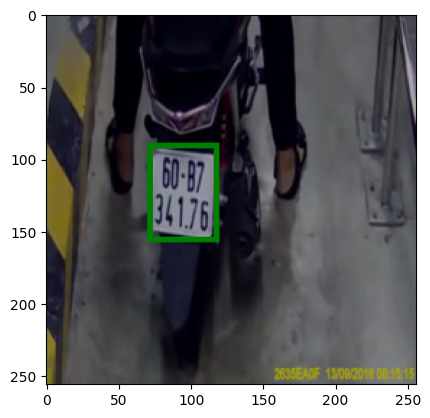

In [18]:
new_image, bbox_new = ToPIL()((new_image, bbox_new))
show_image_with_bb(new_image, bbox_new)

## Data Preparation